In [1]:
import sys
print(sys.executable)

/usr/bin/python3


### Import des bibliothèques

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean,sum
from pyspark.sql.types import IntegerType, DoubleType, BooleanType
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Initialiser Spark
spark = SparkSession.builder \
    .appName("Data Cleaning with PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/18 19:26:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Chargement des données brutes

In [4]:
clients = spark.read.csv("data/raw/clients.csv", header=True, inferSchema=True)

### Nettoyage des données

In [5]:
# Afficher les premières lignes
print("Aperçu des données brutes:")
clients.show(5)

Aperçu des données brutes:
+---+----+----+------------------+----------------+------------+---------------+
|age|sexe|taux|situationFamiliale|nbEnfantsAcharge|2eme voiture|immatriculation|
+---+----+----+------------------+----------------+------------+---------------+
| 25|   F| 159|         En Couple|               2|       false|     3467 SB 72|
| 53|   M| 594|         En Couple|               2|       false|      113 LY 42|
| 20|   F| 949|         En Couple|               1|       false|      925 WK 87|
| 29|   M| 571|         En Couple|               2|       false|     3279 RV 81|
| 47|   M| 502|         En Couple|               1|       false|       82 RZ 54|
+---+----+----+------------------+----------------+------------+---------------+
only showing top 5 rows



In [6]:
# Vérification des types de données
print("\nInformations sur les données:")
clients.printSchema()


Informations sur les données:
root
 |-- age: string (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: string (nullable = true)
 |-- situationFamiliale: string (nullable = true)
 |-- nbEnfantsAcharge: string (nullable = true)
 |-- 2eme voiture: string (nullable = true)
 |-- immatriculation: string (nullable = true)



In [7]:
# Conversion en type numérique en remplaçant les valeurs non convertibles par NaN
clients = clients.withColumn("age", col("age").cast(IntegerType())) \
                 .withColumn("taux", col("taux").cast(DoubleType())) \
                 .withColumn("nbEnfantsAcharge", col("nbEnfantsAcharge").cast(IntegerType()))

In [8]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne:")
clients.select([sum(col(c).isNull().cast("int")).alias(c) for c in clients.columns]).show()


Valeurs manquantes par colonne:


+---+----+----+------------------+----------------+------------+---------------+
|age|sexe|taux|situationFamiliale|nbEnfantsAcharge|2eme voiture|immatriculation|
+---+----+----+------------------+----------------+------------+---------------+
|193|   0| 194|                 0|             200|           0|              0|
+---+----+----+------------------+----------------+------------+---------------+



In [9]:
# Compter les occurrences pour chaque colonne de type 'string'
for col_name in clients.columns:
    if dict(clients.dtypes)[col_name] == 'string':
        print(f"Valeurs uniques pour {col_name}:")
        clients.groupBy(col_name).count().show()

Valeurs uniques pour sexe:
+--------+-----+
|    sexe|count|
+--------+-----+
| Féminin|  322|
|       F|29388|
|Masculin|  684|
|       M|68283|
|     N/D|   86|
|   Femme|  289|
|        |  102|
|   Homme|  743|
|       ?|  103|
+--------+-----+

Valeurs uniques pour situationFamiliale:
+------------------+-----+
|situationFamiliale|count|
+------------------+-----+
|       Célibataire|29841|
|              Seul|  282|
|          Divorcée|   50|
|             Seule| 4989|
|               N/D|  111|
|                  |  110|
|         En Couple|63855|
|                 ?|   98|
|          Marié(e)|  664|
+------------------+-----+

Valeurs uniques pour 2eme voiture:
+------------+-----+
|2eme voiture|count|
+------------+-----+
|       false|86845|
|            |  118|
|           ?|  102|
|        true|12935|
+------------+-----+

Valeurs uniques pour immatriculation:


+---------------+-----+
|immatriculation|count|
+---------------+-----+
|     9714 TO 25|    1|
|     5967 WQ 94|    1|
|     3395 SS 66|    1|
|     5259 BF 13|    1|
|     9415 LT 85|    1|
|     5745 DV 76|    1|
|     4802 OQ 17|    1|
|     7390 NS 90|    1|
|     2608 GI 87|    1|
|     8776 HZ 18|    1|
|     9154 HJ 69|    1|
|     5325 NW 97|    1|
|     3767 WS 45|    1|
|     5832 SC 72|    1|
|     1896 FT 39|    1|
|     7573 KO 37|    1|
|     8684 AE 41|    1|
|     5175 AB 10|    1|
|     9689 KA 72|    1|
|     7007 GF 18|    1|
+---------------+-----+
only showing top 20 rows



In [10]:
# Remplacer les valeurs incorrectes (erreurs de saisie) par NULL
clients = clients.replace(['?', 'N/D', ' '], None)

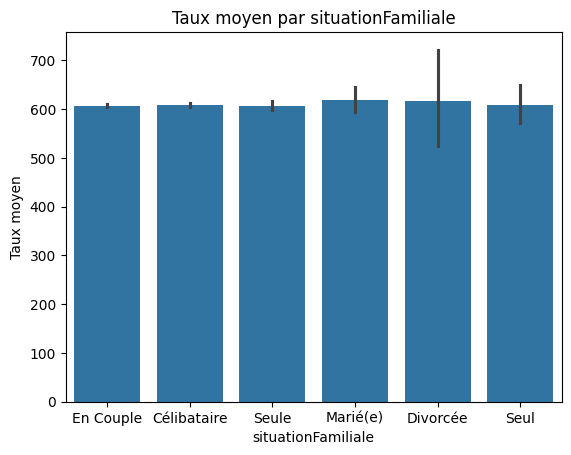

In [11]:
# Analyse des variables catégoriques
if 'situationFamiliale' in clients.columns and 'taux' in clients.columns:
    sns.barplot(x='situationFamiliale', y='taux', data=clients.toPandas())
    plt.title('Taux moyen par situationFamiliale')
    plt.xlabel('situationFamiliale')
    plt.ylabel('Taux moyen')
    plt.show()

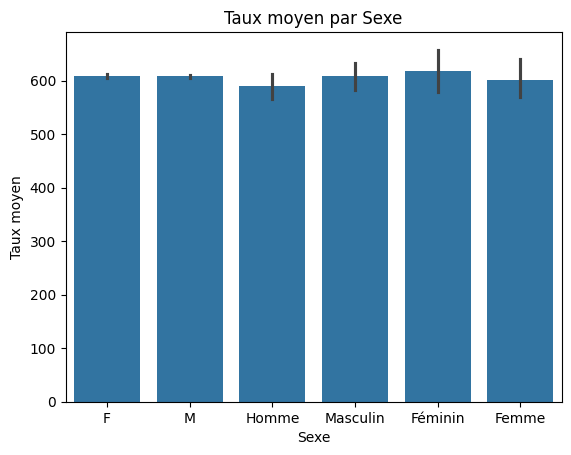

In [12]:
if 'sexe' in clients.columns and 'taux' in clients.columns:
    sns.barplot(x='sexe', y='taux', data=clients.toPandas())
    plt.title('Taux moyen par Sexe')
    plt.xlabel('Sexe')
    plt.ylabel('Taux moyen')
    plt.show()

In [13]:
# Remplacer les valeurs dans la colonne "sexe"
clients = clients.withColumn("sexe", when(col("sexe") == "Homme", "M")
                                      .when(col("sexe") == "Masculin", "M")
                                      .when(col("sexe") == "Féminin", "F")
                                      .when(col("sexe") == "Femme", "F")
                                      .otherwise(col("sexe")))

In [14]:
# Remplacer les valeurs dans la colonne "situationFamiliale"
clients = clients.withColumn("situationFamiliale", when(col("situationFamiliale") == "Seule", "Célibataire")
                                                  .when(col("situationFamiliale") == "Seul", "Célibataire")
                                                  .otherwise(col("situationFamiliale")))

In [15]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne:")
clients.select([sum(col(c).isNull().cast("int")).alias(c) for c in clients.columns]).show()


Valeurs manquantes par colonne:
+---+----+----+------------------+----------------+------------+---------------+
|age|sexe|taux|situationFamiliale|nbEnfantsAcharge|2eme voiture|immatriculation|
+---+----+----+------------------+----------------+------------+---------------+
|193| 291| 194|               319|             200|         220|              0|
+---+----+----+------------------+----------------+------------+---------------+



In [16]:
# Recherche des doublons
duplicates = clients.count() - clients.dropDuplicates().count()
print(f"\nNombre de doublons : {duplicates}")


Nombre de doublons : 0


In [17]:
# Suppression des doublons
clients = clients.dropDuplicates()

In [18]:
# Statistiques descriptives
clients.describe().show()

25/01/18 19:27:12 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----+-----------------+------------------+------------------+------------+---------------+
|summary|               age| sexe|             taux|situationFamiliale|  nbEnfantsAcharge|2eme voiture|immatriculation|
+-------+------------------+-----+-----------------+------------------+------------------+------------+---------------+
|  count|             99807|99709|            99806|             99681|             99800|       99780|         100000|
|   mean|  43.7333353372008| NULL| 607.800502975773|              NULL|1.2451503006012024|        NULL|           NULL|
| stddev|18.355479537193663| NULL|336.2791211783175|              NULL|1.3886242706212781|        NULL|           NULL|
|    min|                -1|    F|             -1.0|       Célibataire|                -1|       false|        0 AJ 71|
|    max|                84|    M|           1399.0|          Marié(e)|                 4|        true|     9999 LP 21|
+-------+------------------+-----+------

### Gérer les valeurs manquantes

In [19]:
# Gérer les valeurs manquantes
# Création d'un nouveau DataFrame pour Imputation et Suppression
clients_imputed = clients
clients_dropped = clients

In [20]:
# Remplacement des valeurs manquantes pour les colonnes numériques par la médiane
for col_name in ['age', 'taux', 'nbEnfantsAcharge']:
    median_value = clients_imputed.approxQuantile(col_name, [0.5], 0.01)[0]
    clients_imputed = clients_imputed.withColumn(col_name, when(col(col_name).isNull(), median_value).otherwise(col(col_name)))

In [21]:
# Remplacement des valeurs manquantes pour les colonnes catégorielles par la valeur la plus fréquente
for col_name in ['sexe', 'situationFamiliale', '2eme voiture']:
    mode_value = clients_imputed.groupBy(col_name).count().orderBy(col("count").desc()).first()[0]
    clients_imputed = clients_imputed.withColumn(col_name, when(col(col_name).isNull(), mode_value).otherwise(col(col_name)))

In [22]:
# Pourcentage de valeurs manquantes
print("Pourcentage de valeurs manquantes par colonne:")
for col_name in clients.columns:
    null_count = clients.filter(col(col_name).isNull()).count()
    total_count = clients.count()
    print(f"{col_name}: {(null_count / total_count) * 100:.2f}%")

Pourcentage de valeurs manquantes par colonne:
age: 0.19%
sexe: 0.29%
taux: 0.19%
situationFamiliale: 0.32%
nbEnfantsAcharge: 0.20%
2eme voiture: 0.22%
immatriculation: 0.00%


In [23]:
# Pourcentage de valeurs manquantes
print("Pourcentage de valeurs manquantes par colonne:")
for col_name in clients.columns:
    null_count = clients.filter(col(col_name).isNull()).count()
    total_count = clients.count()
    print(f"{col_name}: {(null_count / total_count) * 100:.2f}%")

Pourcentage de valeurs manquantes par colonne:
age: 0.19%
sexe: 0.29%
taux: 0.19%
situationFamiliale: 0.32%
nbEnfantsAcharge: 0.20%
2eme voiture: 0.22%
immatriculation: 0.00%


In [24]:
# Suppression des lignes avec des valeurs manquantes
clients_dropped = clients_dropped.na.drop()

In [25]:
# Vérification des valeurs manquantes dans le nouveau DataFrame
print("\nValeurs manquantes après suppression:")
clients_dropped.select([sum(col(c).isNull().cast("int")).alias(c) for c in clients_dropped.columns]).show()


Valeurs manquantes après suppression:


+---+----+----+------------------+----------------+------------+---------------+
|age|sexe|taux|situationFamiliale|nbEnfantsAcharge|2eme voiture|immatriculation|
+---+----+----+------------------+----------------+------------+---------------+
|  0|   0|   0|                 0|               0|           0|              0|
+---+----+----+------------------+----------------+------------+---------------+



### Visualisation des données

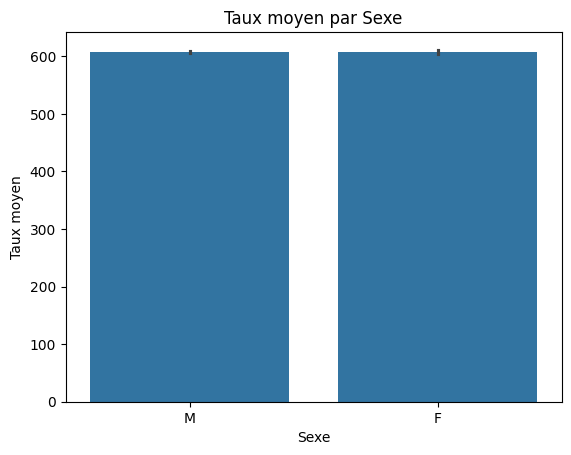

In [26]:
# Analyse des variables catégoriques
if 'sexe' in clients_imputed.columns and 'taux' in clients_imputed.columns:
    sns.barplot(x='sexe', y='taux', data=clients_imputed.toPandas())
    plt.title('Taux moyen par Sexe')
    plt.xlabel('Sexe')
    plt.ylabel('Taux moyen')
    plt.show()

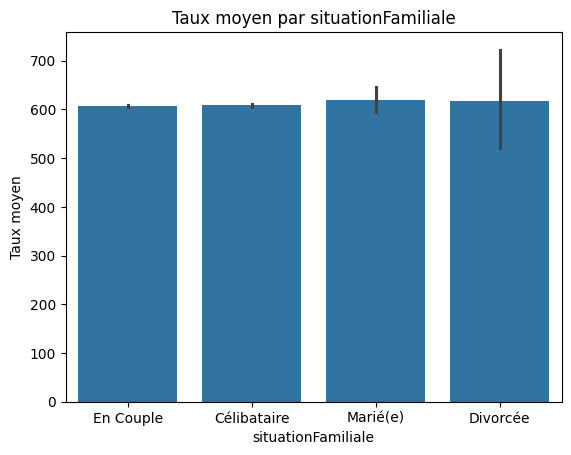

In [27]:
if 'situationFamiliale' in clients_imputed.columns and 'taux' in clients_imputed.columns:
    sns.barplot(x='situationFamiliale', y='taux', data=clients_imputed.toPandas())
    plt.title('Taux moyen par situationFamiliale')
    plt.xlabel('situationFamiliale')
    plt.ylabel('Taux moyen')
    plt.show()

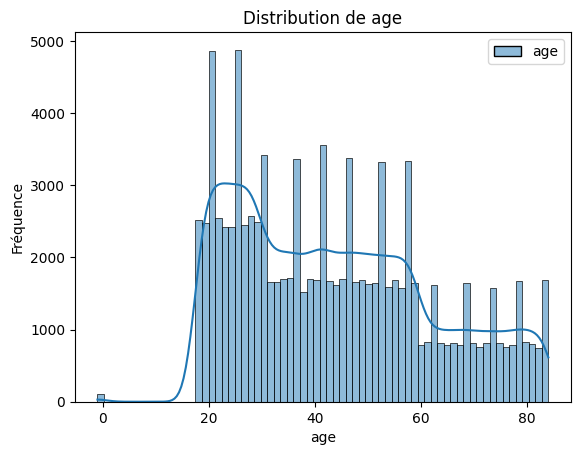

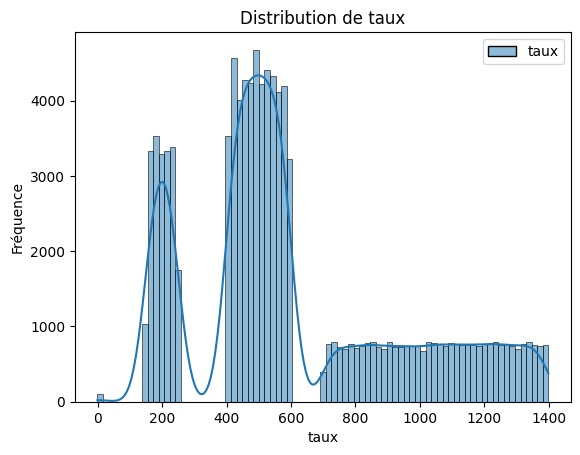

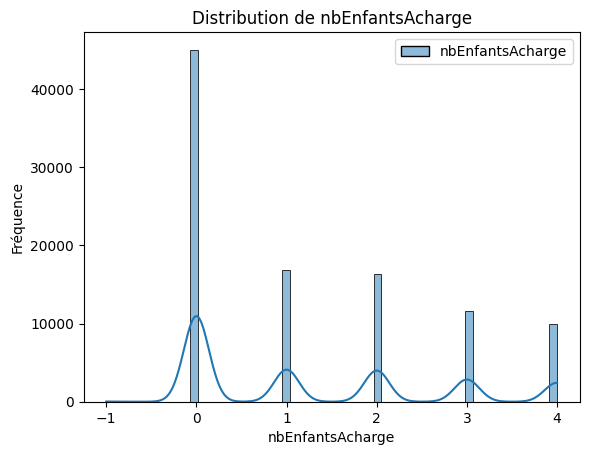

In [28]:
# Histogrammes pour les variables numériques
num_cols = [f.name for f in clients_imputed.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]
for col_name in num_cols:
    plt.figure()
    sns.histplot(clients_imputed.select(col_name).toPandas(), kde=True)
    plt.title(f'Distribution de {col_name}')
    plt.xlabel(col_name)
    plt.ylabel('Fréquence')
    plt.show()

In [29]:
# Filtrer les valeurs hors des contraintes
constraints = {
    'age': (18, 84),
    'taux': (544, 74185),
    'nbEnfantsAcharge': (0, 4)
}

for col_name, (min_val, max_val) in constraints.items():
    clients_imputed = clients_imputed.filter((col(col_name) >= min_val) & (col(col_name) <= max_val))

In [30]:
# Encodage des variables catégoriques
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index").fit(clients_imputed) for col_name in ['sexe', 'situationFamiliale', '2eme voiture']]
for indexer in indexers:
    clients_imputed = indexer.transform(clients_imputed)

In [31]:
# Afficher les colonnes après encodage
print("Colonnes après encodage :")
clients_imputed.printSchema()

Colonnes après encodage :
root
 |-- age: double (nullable = true)
 |-- sexe: string (nullable = true)
 |-- taux: double (nullable = true)
 |-- situationFamiliale: string (nullable = true)
 |-- nbEnfantsAcharge: double (nullable = true)
 |-- 2eme voiture: string (nullable = true)
 |-- immatriculation: string (nullable = true)
 |-- sexe_index: double (nullable = false)
 |-- situationFamiliale_index: double (nullable = false)
 |-- 2eme voiture_index: double (nullable = false)



In [32]:
# Sélectionner les colonnes numériques et les colonnes catégorielles encodées
num_cols = [f.name for f in clients_imputed.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType))]
encoded_cat_cols = [f"{col_name}_index" for col_name in categorical_cols]
selected_cols = num_cols + encoded_cat_cols

NameError: name 'categorical_cols' is not defined

In [ ]:
# Convertir en Pandas pour la visualisation
corr_matrix = clients_imputed.select([col(c) for c in selected_cols]).toPandas().corr()

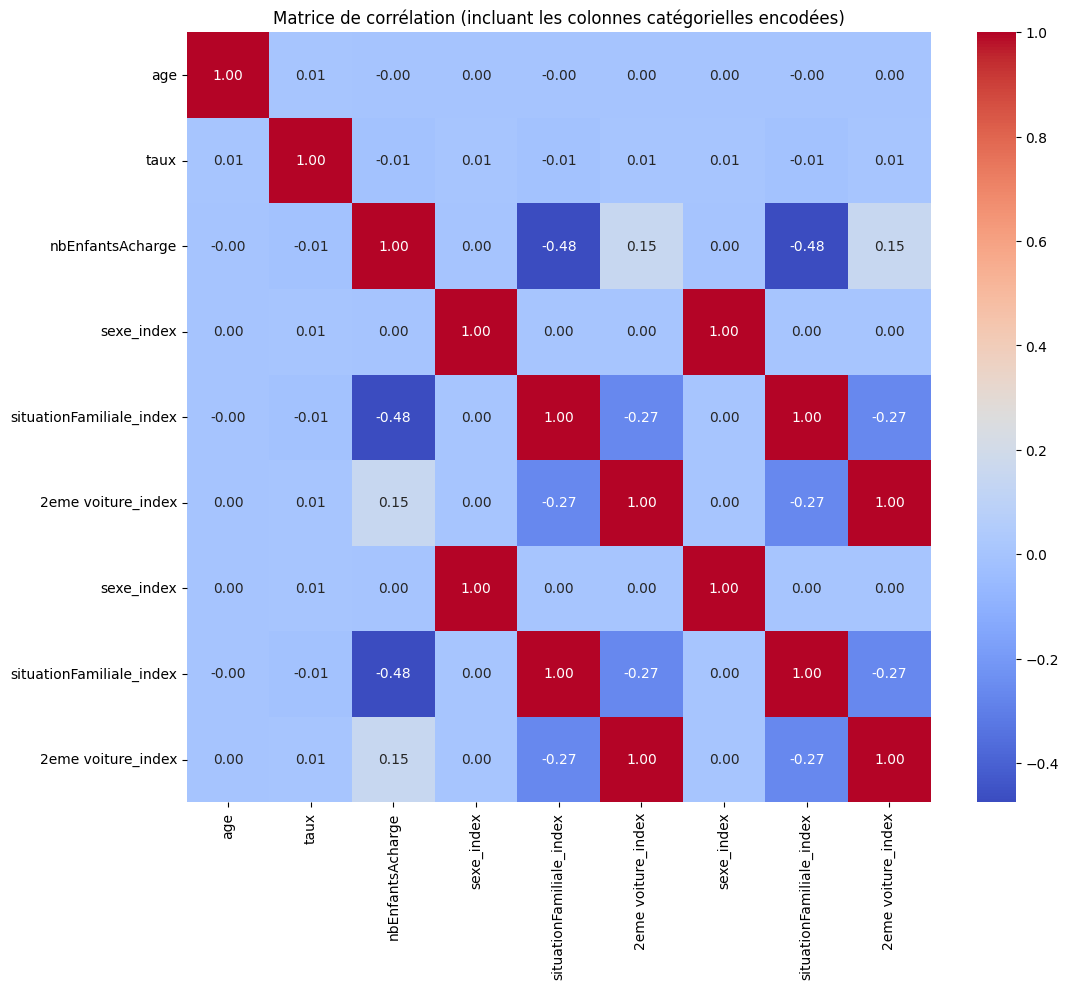

In [ ]:
# Afficher la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation (incluant les colonnes catégorielles encodées)')
plt.show()

In [138]:
# Sauvegarder les données nettoyées
clients_imputed.write.csv("data/processed/clients_processed.csv", header=True, mode="overwrite")
print("\nDonnées nettoyées sauvegardées dans 'clients_processed.csv'")

25/01/18 19:09:55 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE


Données nettoyées sauvegardées dans 'clients_processed.csv'


25/01/18 19:10:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE